# Ronchi grating frames analysis of ADC effects

In [1668]:
import matplotlib.pyplot as plt  
import pandas as pd  
import os
import numpy as np
from astropy.io import fits 

from PIL import Image


#conda install -c astropy photutils

from photutils import centroid_com, centroid_1dg, centroid_2dg

#need to install newer version of scipy from conda, need 1.2 or newer for find_peaks function

from scipy.signal import find_peaks

#for animations
from matplotlib import animation, rc
from IPython.display import HTML

#patches
from matplotlib import patches as patches


from astropy.modeling import models, fitting

#from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

from astropy.modeling.models import custom_model

from scipy.optimize import curve_fit

import yaml
import csv
import datetime

In [1669]:
#@custom_model
def gauss_offset(x, amplitude=1., mean=0., stddev=1., H=0.):
    
    return H + amplitude * np.exp(-(x - mean) ** 2 / (2 * stddev ** 2))

def gauss_fit(H,x, y):
    mean = sum(x * y) / sum(y)
    stddev = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss_offset, x, y, p0=[H,max(y), mean, stddev])
    return popt

In [3024]:
event_timestamp_list = [
#done    '20200114.061041'
#done     '20200114.061137'
#done    '20200114.061204'
#done    '20200114.061305'
#done    '20200114.061331'
#done    '20200114.061424'
#done    '20200114.061521'
#done    '20200114.061630'
#done    '20200114.061757'
#done    '20200114.061905'
#done    '20200114.061937'
#done    '20200114.062150'
#done    '20200114.062432'
#done    '20200114.062528'
#done    '20200114.062730'
#done    '20200114.062834'
#different star nu.02 CMa
#done    '20200114.064427'
#done    '20200114.064522'
#done    '20200114.064605'
#done    '20200114.064650'
#done    '20200114.064901'
#different star kap CMa
#done    '20200114.065609'
#different star bet Tau
#done    '20200114.070555'
#done    '20200114.070627'
#done    '20200114.070728'
#done    '20200114.070815'
#done    '20200114.070918'
#done    '20200114.070950'
#done    '20200114.071100'
#done    '20200114.071216'
#done    '20200114.071500'
    '20200114.071716'
#    '20200114.071902'
#    '20200114.072050'
#    '20200114.072233'
#    '20200114.072416'
#    '20200114.072529'
#    '20200114.072609'
#    '20200114.072722'
#    '20200114.072837'
#    '20200114.072947'
#    '20200114.073119'
#    '20200114.073545'
#    '20200114.073822'
#    '20200114.074017'
#    '20200114.074317'
#    '20200114.074519'
#    '20200114.074642'
#    '20200114.074713'
#    '20200114.074845'
#    '20200114.075114'
#    '20200114.075225'
#    '20200114.075325'
#    '20200114.075432'
#    '20200114.075621'
#    '20200114.075731'
#    '20200114.080222'
#    '20200114.080345'
#    '20200114.080540'
#    '20200114.080617'
#    '20200114.080715'
#    '20200114.080750'
#    '20200114.080829'
#    '20200114.080923'
]

In [3025]:
event_timestamp=event_timestamp_list[0]
print(event_timestamp)

20200114.071716


In [3026]:
len(event_timestamp_list)

1

In [3027]:
raunche_df=pd.read_csv('raunche_inputs.csv')

In [3028]:
raunche_df.set_index('timestamp',inplace=True,drop=False)

In [3029]:
raunche_df.loc[event_timestamp]

timestamp                       20200114.071716
bigbox                                      250
hafbox                                       40
pixcount_cutoff                             650
goffset_stellar_centroidx                     0
goffset_stellar_centroidy                     0
goffset_hwing1                                0
goffset_hwing2                                0
goffset_vwing1                                0
goffset_vwing2                                0
h1r                                   (50, 100)
h2r                                  (250, 300)
v1r                                   (50, 100)
v2r                                  (250, 300)
polynom_h1                                    1
polynom_h2                                    1
polynom_v1                                    1
polynom_v2                                    1
airmass                                    1.09
target_name                  bet Tau - HD 35497
Name: 20200114.071716, dtype: object

## import our fits file

In [3030]:
filename="gf-cam." + raunche_df.loc[event_timestamp]['timestamp']

path = "c:/cloudstor/codestore/jupyter/adc-proc/ADC_test_14Jan2020/"

im = fits.open(path + filename + ".fits")
imarray0=im[0].data

### peek at the image array

In [3031]:
print(imarray0)

[[520 414 417 ... 453 488 493]
 [495 490 477 ... 499 485 455]
 [486 463 472 ... 485 520 529]
 ...
 [416 456 429 ... 438 441 492]
 [410 433 399 ... 444 457 497]
 [512 515 457 ... 481 460 468]]


### preview the image

In [3032]:
#fig,ax = plt.subplots()
#fig.set_size_inches(20, 15)
#ax.imshow(imarray0,origin='lower')


### Centroid the whole image
doing a 1D bin then getting the max seems to find the centroid most accurately

In [3033]:
cx, cy = centroid_com(imarray0)
print((cx,cy ))   

#if it fails, use max method
csumx=imarray0.sum(axis=0)
csumy=imarray0.sum(axis=1)

cx=(np.argmax(csumx))
cy=(np.argmax(csumy))
print(cx,cy)

(515.5450943355474, 508.890791164308)
492 504


In [3034]:
hafbox=40

bigbox=250

imarray=imarray0[int(cy)-bigbox:int(cy)+bigbox,int(cx)-bigbox:int(cx)+bigbox]

cx, cy = centroid_com(imarray)

stellarbox=imarray[int(cy)-hafbox:int(cy)+hafbox,int(cx)-hafbox:int(cx)+hafbox]
#stellarbox=imarray[0:495,int(cy)-hafbox:int(cy)+hafbox]

#xmean=stellarbox.sum(axis=0)
#ymean=stellarbox.sum(axis=1)



#csx=(np.argmax(xmean))
#csy=(np.argmax(ymean))


#csx=np.argmax(stellarbox,axis=0)
#csy=np.argmax(stellarbox,axis=1)

#sx = cx-hafbox+csx
#sy = cy-hafbox+csy
#print(sx,sy)

#print(sx)
#print(sy)


### crop preview

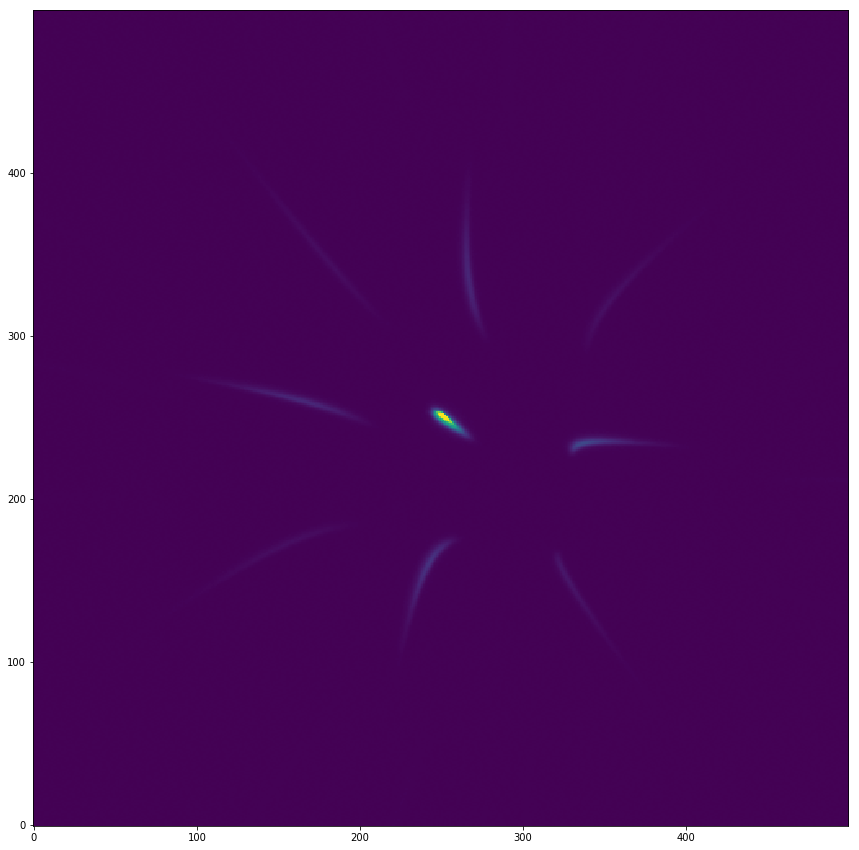

In [3035]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(imarray,origin='lower')

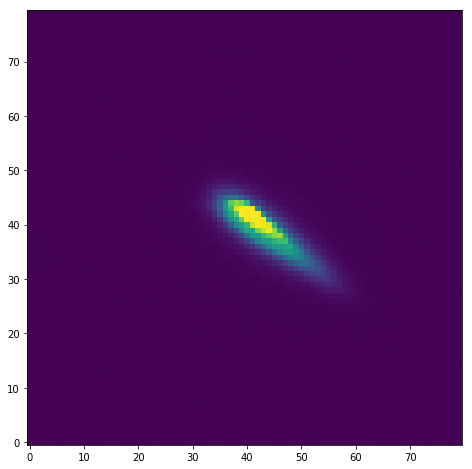

In [3036]:
fig,ax = plt.subplots()

fig.set_size_inches(8, 8)
ax.imshow(stellarbox,origin='lower')

In [3037]:
raunche_df.at[event_timestamp,'goffset_stellar_centroidx']=1
raunche_df.at[event_timestamp,'goffset_stellar_centroidy']=0.1
goffset_stellar_centroidx=raunche_df.loc[event_timestamp]['goffset_stellar_centroidx']
goffset_stellar_centroidy=raunche_df.loc[event_timestamp]['goffset_stellar_centroidy']

In [3038]:
#print(xmean)

xsum=stellarbox.sum(axis=0)
ysum=stellarbox.sum(axis=1)

print('x direction')

data=xsum
y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
x=np.arange(80)
H, A, x0, stddev = gauss_fit(goffset_stellar_centroidx,x, y)
print(H)
print(A)
print(x0)
print(stddev)
csx=A

print('y direction')

data=ysum
y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
x=np.arange(80)
H, A, x0, stddev = gauss_fit(goffset_stellar_centroidy,x, y)
print(H)
print(A)
print(x0)
print(stddev)
csy=A

#csx=(np.argmax(xsum))
#csy=(np.argmax(ysum))

sx = cx-hafbox+csx
sy = cy-hafbox+csy

x direction
0.9711591916908523
42.37032339041195
5.322729299513064
0.00758029467160183
y direction
0.9938508633844505
39.587112501070024
-4.25409302886054
0.005378123062957053


In [3039]:
print(sx)
print(sy)

253.24643236324707
248.58826564330883


### plot the centroid coordinates

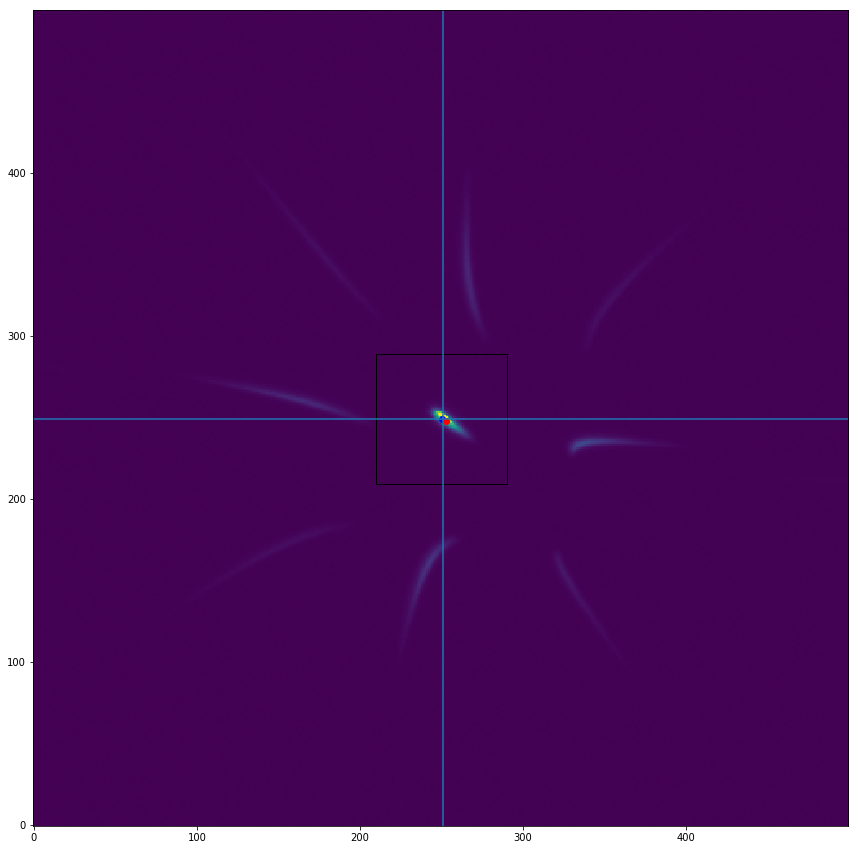

In [3040]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(imarray,origin='lower')


ax.plot(int(cx),int(cy), 'bo')

ax.plot(int(sx),int(sy), 'ro')

p = plt.Rectangle((int(cx)-hafbox, int(cy)-hafbox), 2*hafbox, 2*hafbox, fill=False)
#p = plt.Rectangle((200, 100), 2*hafbox, 2*hafbox, fill=False)
#p.set_transform(ax.transAxes)
#p.set_clip_on(False)
ax.add_patch(p)

#ax.plot(200,100,'bo')
ax.axvline(cx)
ax.axhline(cy)




### plot a 120x400 crop of the image

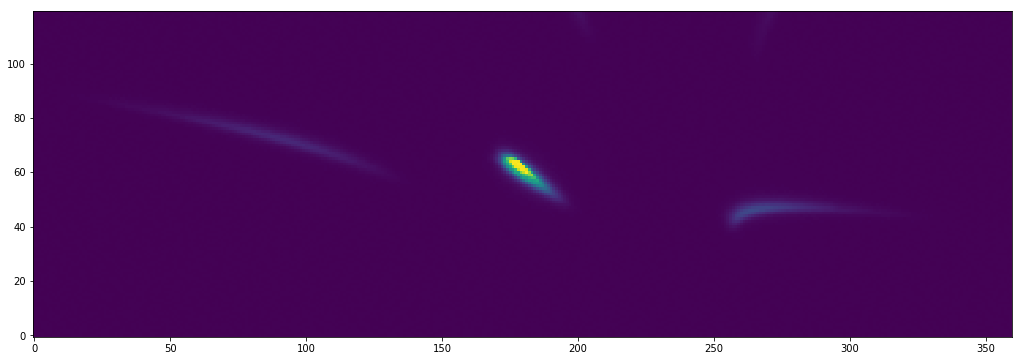

In [3041]:
bds=60
bdl=180

subim=imarray[int(sy)-bds:int(sy)+bds,int(sx)-bdl:int(sx)+bdl]

fig,ax = plt.subplots()

fig.set_size_inches(18, 6)
#ax.imshow(subim,origin='lower',cmap='gray')

ax.imshow(subim,origin='lower')

#ax.plot(int(cy),int(cx), 'bo')

In [3042]:
print(int(sy)-bds)
print(int(sy)+bds)
print(int(sx)-bdl)
print(int(sx)+bdl)

188
308
73
433


### populate an array max intensity values of each column

In [3043]:
hormax=np.amax(subim,axis=0)

print(hormax)


[  565   544   547   549   596   557   571   572   553   540   553   593
   564   542   653   605   636   672   656   665   698   706   711   754
   778   783   859   894   915  1015   995  1053  1099  1068  1196  1233
  1264  1253  1222  1262  1321  1377  1389  1415  1402  1420  1631  1652
  1790  1749  1851  1892  1979  1889  1875  1992  2298  2282  2343  2346
  2611  2656  2696  2767  2749  2959  3021  2993  2922  3155  3355  3370
  3204  3347  3539  3638  3670  3590  3718  3961  3877  4003  3990  4092
  4176  4098  3978  4301  4257  4217  4232  4316  4341  4144  4258  4376
  4293  4109  4173  4257  3848  4013  4053  3908  3691  3795  3678  3420
  3480  3306  3179  3169  3123  2971  2899  2719  2691  2591  2442  2158
  2128  2000  2023  1873  1808  1610  1521  1384  1404  1233  1185  1068
   934   901   799   751   692   680   629   597   591   587   601   619
   619   577   547   569   563   578   591   543   569   582   563   553
   608   545   578   547   606   553   577   591   

### populate an array with the index of the column pixel intensity max

In [3044]:
horargmax=np.argmax(subim,axis=0)

horargmax=horargmax.astype(float)

print(horargmax)

[ 86.  69.  87.   1.  19.  70.  91.  58.  86.  61.  89.  89.  60.  88.
  88.  88.  88.  87.  88.  87.  87.  87.  86.  86.  86.  86.  86.  86.
  85.  85.  85.  85.  85.  85.  84.  84.  84.  84.  84.  84.  83.  83.
  83.  83.  82.  82.  82.  82.  82.  81.  81.  81.  81.  81.  80.  80.
  80.  80.  80.  80.  79.  79.  79.  79.  78.  78.  78.  78.  78.  77.
  77.  77.  77.  77.  76.  76.  76.  76.  75.  75.  75.  75.  74.  74.
  74.  74.  73.  73.  73.  73.  72.  72.  72.  72.  71.  71.  71.  70.
  70.  70.  69.  69.  69.  69.  69.  68.  68.  68.  67.  67.  67.  66.
  66.  65.  65.  65.  64.  64.  64.  63.  63.  63.  62.  62.  62.  62.
  61.  60.  60.  60.  59.  59.  58.  58.  58.  57.  56.  57.  56.  56.
 119. 119. 119. 119. 119. 119.  96.  91. 104.  32.  37.  10.  44.  66.
  66.  45.  31.  37.  64.  41.  60.  47. 109.  51.  63.  66.  66.  65.
  65.  65.  65.  65.  64.  64.  65.  64.  63.  64.  63.  63.  61.  60.
  60.  59.  58.  57.  56.  55.  54.  54.  53.  52.  52.  51.  50.  49.
  49. 

In [3045]:
cols=2*bdl
rows=2*bds

In [3046]:
X = np.arange(cols)

In [3047]:
pixcount_cutoff=raunche_df.loc[event_timestamp]['pixcount_cutoff']

### NaN out the columns with no data

In [3048]:
hornanargmax=np.copy(horargmax)
for i in X:
    if hormax[int(i)] < pixcount_cutoff:
        hornanargmax[int(i)]=np.nan

In [3049]:
print(hornanargmax)

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  88.  nan  nan  87.  88.  87.  87.  87.  86.  86.  86.  86.  86.  86.
  85.  85.  85.  85.  85.  85.  84.  84.  84.  84.  84.  84.  83.  83.
  83.  83.  82.  82.  82.  82.  82.  81.  81.  81.  81.  81.  80.  80.
  80.  80.  80.  80.  79.  79.  79.  79.  78.  78.  78.  78.  78.  77.
  77.  77.  77.  77.  76.  76.  76.  76.  75.  75.  75.  75.  74.  74.
  74.  74.  73.  73.  73.  73.  72.  72.  72.  72.  71.  71.  71.  70.
  70.  70.  69.  69.  69.  69.  69.  68.  68.  68.  67.  67.  67.  66.
  66.  65.  65.  65.  64.  64.  64.  63.  63.  63.  62.  62.  62.  62.
  61.  60.  60.  60.  59.  59.  58.  58.  58.  57.  56.  57.  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  66.  66.  65.
  65.  65.  65.  65.  64.  64.  65.  64.  63.  64.  63.  63.  61.  60.
  60.  59.  58.  57.  56.  55.  54.  54.  53.  52.  52.  51.  50.  49.
  49. 

## Plot the intensity max position of each column

In [3050]:
print(raunche_df.loc[event_timestamp]['polynom_h1'])
print(raunche_df.loc[event_timestamp]['polynom_h1'])
print(raunche_df.loc[event_timestamp]['h1r'])
print(raunche_df.loc[event_timestamp]['h2r'])

1
1
(50, 100)
(250, 300)


In [3051]:
polynom=1
raunche_df.at[event_timestamp,'polynom_h1']=2
raunche_df.at[event_timestamp,'polynom_h2']=2
raunche_df.at[event_timestamp,'polynom_v1']=2
raunche_df.at[event_timestamp,'polynom_v2']=2
polynom_h1=raunche_df.loc[event_timestamp]['polynom_h1']
polynom_h2=raunche_df.loc[event_timestamp]['polynom_h2']
polynom_v1=raunche_df.loc[event_timestamp]['polynom_v1']
polynom_v2=raunche_df.loc[event_timestamp]['polynom_v2']
#polynom=2

Text(0.5,0,'Pixel Column')

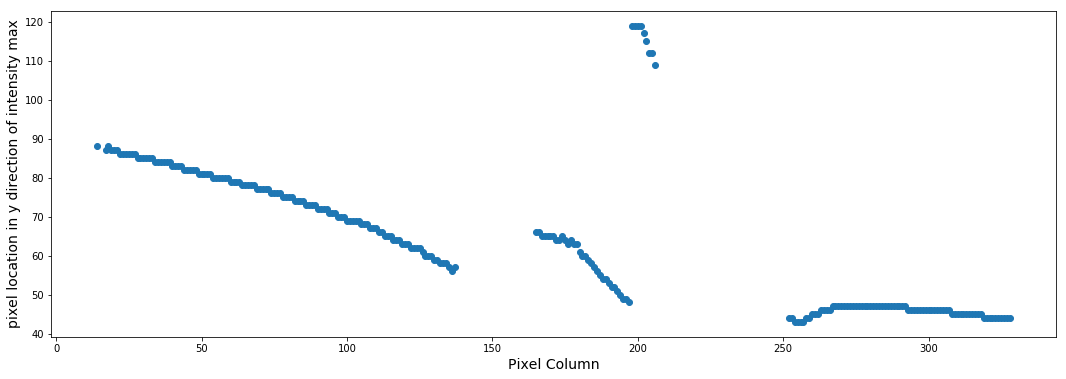

In [3052]:
fig,ax = plt.subplots()

fig.set_size_inches(18, 6)

ax.scatter(X,hornanargmax)
ax.set_ylabel("pixel location in y direction of intensity max",size=14)
ax.set_xlabel("Pixel Column",size=14)
#plt.scatter(np.linspace(0,60,60),horargmax[60:120])

In [3071]:
raunche_df.at[event_timestamp,'h1r']='(40,125)'
raunche_df.at[event_timestamp,'h2r']='(260,320)'
h1r=eval(raunche_df.loc[event_timestamp]['h1r'])
h2r=eval(raunche_df.loc[event_timestamp]['h2r'])

In [3072]:
#code to see gaussian fit of one row

#data=subim[:,70]
#y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
    
#x=np.arange(rows)
#plt.scatter(x,data)

In [3073]:

#h1r=(50,100)
#h2r=(270,330)

#h1r=(20,125)
#h2r=(250,330)



horwing1 = np.polyfit(X[h1r[0]:h1r[1]], horargmax[h1r[0]:h1r[1]], polynom)
print(horwing1)

horwing2 = np.polyfit(X[h2r[0]:h2r[1]], horargmax[h2r[0]:h2r[1]], polynom)
print(horwing2)

[-0.25170999 94.34610123]
[-2.73409280e-02  5.40818653e+01]


In [3088]:
raunche_df.at[event_timestamp,'goffset_hwing1']=0.2
raunche_df.at[event_timestamp,'goffset_hwing2']=0
goffset_hwing1=raunche_df.loc[event_timestamp]['goffset_hwing1']
goffset_hwing2=raunche_df.loc[event_timestamp]['goffset_hwing2']

In [3089]:
raunche_df.loc[event_timestamp]['goffset_hwing1']

0.2

In [3090]:
ghorwing1 = []

X1=range(h1r[0],h1r[1],1)

for i in X1:
    whichcol = i
    data=subim[:,whichcol]
    y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
    
    x=np.arange(rows)
    
    H, A, x0, stddev = gauss_fit(goffset_hwing1,x, y)
    
    ghorwing1.append(A)
    
ghorwing1=np.array(ghorwing1)

ghorwing2 = []

X2=range(h2r[0],h2r[1],1)

for i in X2:
    whichcol = i
    data=subim[:,whichcol]
    y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
    
    x=np.arange(rows)
    
    H, A, x0, stddev = gauss_fit(goffset_hwing2,x, y)
    
    ghorwing2.append(A)
    
ghorwing2=np.array(ghorwing2)



In [3091]:
print(ghorwing1)
#ghorwing2.shape

[83.52635542 83.27703383 83.01952797 82.79598686 82.74159684 82.63062617
 82.47399682 82.15590342 81.98361787 81.81074854 81.5215685  81.32409828
 81.10269554 80.93702586 80.75521823 80.56745072 80.31387392 80.1885355
 80.04724593 79.74004165 79.4956756  79.26199172 79.07085227 78.91841777
 78.73532523 78.46584141 78.31082032 78.04228931 77.83619086 77.61487734
 77.41176579 77.16901523 76.97628696 76.77308899 76.51249348 76.21252118
 76.03304315 75.7762439  75.56039315 75.3790389  75.07677776 74.83894282
 74.57580601 74.33050292 74.0768764  73.85022964 73.62118169 73.34426932
 73.08847405 72.75966906 72.57251385 72.30632043 72.10125295 71.77716951
 71.51658597 71.2484852  70.95165604 70.70675066 70.37252334 70.03855377
 69.76700607 69.53363338 69.22490771 68.90061677 68.64259604 68.27705617
 67.98334573 67.67994788 67.35533609 67.03606626 66.70330545 66.39110972
 66.1150226  65.71520288 65.40521399 65.06263899 64.650184   64.33909203
 64.02305338 63.62549702 63.25043487 62.93680089 62.

In [3092]:
gaushwing1 = np.polyfit(X1, ghorwing1, polynom_h1)
gh1 = np.poly1d(gaushwing1)
gaushwing2 = np.polyfit(X2, ghorwing2, polynom_h2)
gh2 = np.poly1d(gaushwing2)

In [3093]:
print(gaushwing1)
print(gaushwing2)

[-1.11745432e-03 -6.99504390e-02  8.78586615e+01]
[-2.29974979e-03  1.30411653e+00 -1.37789190e+02]


Text(0.5,1,'slope of horizontal left order from ronchi grating')

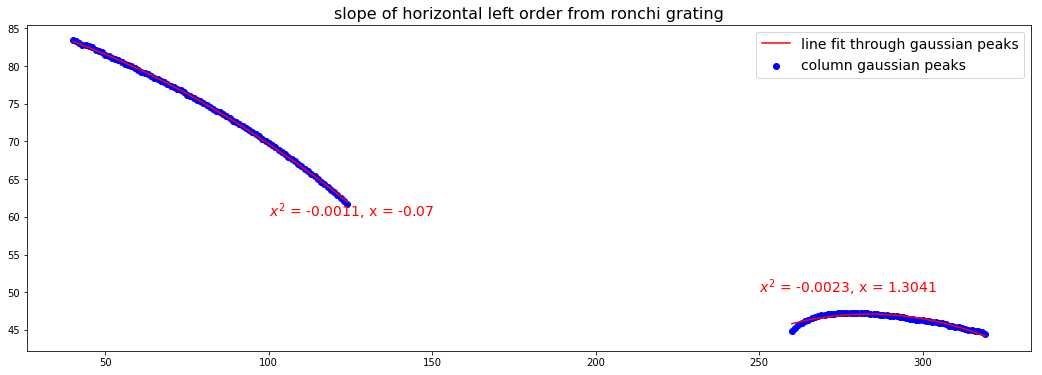

In [3094]:
#m_hdiff=str(abs(round(gauswing2[0]-gauswing1[0],3)))

fig,ax = plt.subplots()

fig.set_size_inches(18, 6)

ax.scatter(X1,ghorwing1, label="column gaussian peaks", color = "blue")
ax.plot(X1,gh1(X1),color='red',label="line fit through gaussian peaks")
ax.scatter(X2,ghorwing2,color = "blue")
ax.plot(X2,gh2(X2),color='red',)
ax.text(100,60,'$x^2$ = ' + str(round(gaushwing1[0],4)) + ', x = ' + str(round(gaushwing1[1],4)),fontsize=14,color='red')
ax.text(250,50,'$x^2$ = ' + str(round(gaushwing2[0],4)) + ', x = ' + str(round(gaushwing2[1],4)),fontsize=14,color='red')
#ax.text(150,20,'diff between hor wings = ' + m_hdiff,fontsize=14,color='red')
ax.legend(fontsize=14)
ax.set_title("slope of horizontal left order from ronchi grating",fontsize=16)

## work in the vertical direction

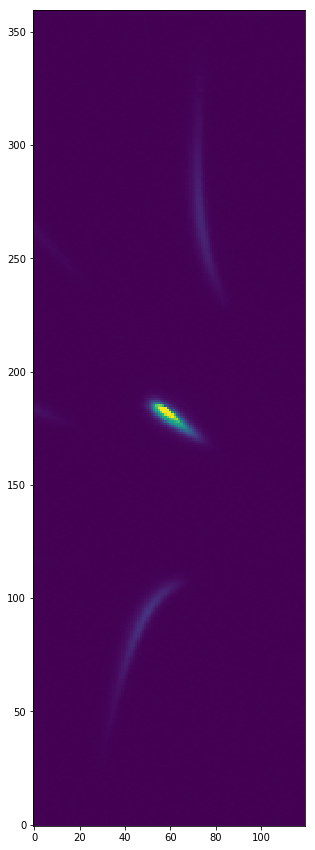

In [3095]:
subvim=imarray[int(sy)-bdl:int(sy)+bdl,int(sx)-bds:int(sx)+bds]

fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
#ax.imshow(subim,origin='lower',cmap='gray')

ax.imshow(subvim, origin='lower')

#ax.plot(int(cy),int(cx), 'bo')

In [3096]:
vermax=np.amax(subvim,axis=1)

print(vermax)


[  538   566   541   557   549   557   557   546   581   549   554   569
   544   566   566   552   590   544   582   558   567   562   595   595
   566   567   571   593   610   613   652   709   698   656   702   719
   710   751   843   834   899   998  1005  1029  1059  1062  1092  1223
  1264  1279  1249  1344  1375  1371  1433  1485  1631  1766  1761  1854
  1930  1908  1964  2129  2121  2237  2666  2675  2676  2765  2974  3085
  3075  3149  3293  3747  3724  3615  3916  4159  4054  4291  4330  4571
  4795  4705  5128  5071  5231  5281  5165  5393  5528  5458  5677  5605
  5382  5462  5343  5007  4654  4575  4386  3994  3526  3042  2509  1923
  1491  1111   853   691   614   622   706   707   753   692   673   566
   561   543   562   560   558   563   551   554   551   564   565   541
   568   578   556   566   563   552   570   561   561   572   572   573
   565   563   578   584   568   543   546   608   578   558   549   570
   568   591   581   567   569   603   596   589   

### populate an array with the index of the column pixel intensity max

In [3097]:
verargmax=np.argmax(subvim,axis=1)

verargmax=verargmax.astype(float)

print(verargmax)

[119.  95.  23.  81.  72.  45.  62. 112.  84. 108.   3.  85.  51.  46.
  91.  12.  57.  81.  87.  60.  68.  29.  29.  47.  63.  72.  30.  30.
  31.  30.  31.  31.  31.  32.  31.  32.  32.  32.  32.  32.  33.  33.
  33.  33.  33.  33.  34.  34.  34.  34.  35.  35.  35.  36.  36.  36.
  36.  37.  37.  37.  37.  37.  38.  38.  38.  38.  39.  39.  39.  40.
  40.  40.  41.  41.  41.  42.  42.  42.  43.  43.  44.  44.  44.  45.
  45.  45.  46.  46.  47.  47.  48.  48.  49.  49.  50.  51.  51.  52.
  53.  54.  55.  55.  57.  58.  58.  60.  61.  62.  63.  62.  63.  62.
  66.   1.   0.   1.   0.   0.   1.   0.  86. 101.   8.  71. 108.  89.
  55.  58.  72.  74.  43. 119.  11.  93. 111.  29. 119.  74.  80.   7.
 100.  80. 108.  97.  82. 109. 107.  40. 104.  91.  54.  36.  29. 110.
  32.  12.  51.  30.  50. 113.  65.  67.  78.  56.  78.  74.  75.  75.
  73.  73.  72.  71.  70.  69.  67.  66.  65.  65.  64.  63.  61.  59.
  58.  58.  57.  55.  54.  54.  54.  53.  52.  54.  51.  54.  60.  53.
  61. 

### NaN out the columns with no data

In [3098]:
vernanargmax=np.copy(verargmax)
for i in X:
    if vermax[int(i)] < pixcount_cutoff:
        vernanargmax[int(i)]=np.nan

In [3099]:
print(vernanargmax)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 31. 31. 31. 32. 31. 32.
 32. 32. 32. 32. 33. 33. 33. 33. 33. 33. 34. 34. 34. 34. 35. 35. 35. 36.
 36. 36. 36. 37. 37. 37. 37. 37. 38. 38. 38. 38. 39. 39. 39. 40. 40. 40.
 41. 41. 41. 42. 42. 42. 43. 43. 44. 44. 44. 45. 45. 45. 46. 46. 47. 47.
 48. 48. 49. 49. 50. 51. 51. 52. 53. 54. 55. 55. 57. 58. 58. 60. 61. 62.
 63. 62. 63. 62. nan nan  0.  1.  0.  0.  1. nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan 74. 75. 75. 73. 73. 72. 71. 70. 69. 67. 66. 65. 65. 64. 63.
 61. 59. 58. 58. 57. 55. 54. 54. 54. 53. 52. 54. 51. 54. nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 85. 85. 83. 83. 83. 82.
 82. 82. 82. 81. 80. 80. 80. 79. 79. 78. 79. 78. 78

## Plot the intensity max position of each row

Text(0.5,0,'Pixel Column')

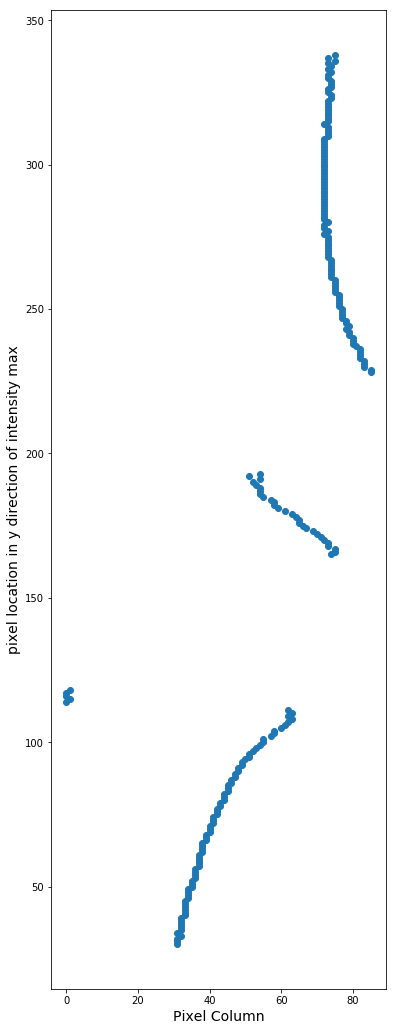

In [3100]:
plt.figure(figsize=(6,18))
plt.scatter(vernanargmax,X)
plt.ylabel("pixel location in y direction of intensity max",size=14)
plt.xlabel("Pixel Column",size=14)
#plt.scatter(np.linspace(0,60,60),horargmax[60:120])



In [3163]:
raunche_df.at[event_timestamp,'v1r']='(35,100)'
raunche_df.at[event_timestamp,'v2r']='(230,330)'
v1r=eval(raunche_df.loc[event_timestamp]['v1r'])
v2r=eval(raunche_df.loc[event_timestamp]['v2r'])


In [3164]:
print(v1r)
print(v2r)

(35, 100)
(230, 330)


In [3165]:
#v1r=(60,140)
#v1r=(30,90)
#v2r=(250,300)

#polynom=1


verwing1 = np.polyfit(X[v1r[0]:v1r[1]], verargmax[v1r[0]:v1r[1]], polynom)
print(verwing1)

verwing2 = np.polyfit(X[v2r[0]:v2r[1]], verargmax[v2r[0]:v2r[1]], polynom)
print(verwing2)

[ 0.32023601 18.69803322]
[-8.30363036e-02  9.76886469e+01]


In [3166]:
Y1=range(v1r[0],v1r[1],1)
print(Y1)

range(35, 100)


In [3173]:
raunche_df.at[event_timestamp,'goffset_vwing1']=0
raunche_df.at[event_timestamp,'goffset_vwing2']=0.05
goffset_vwing1=raunche_df.loc[event_timestamp]['goffset_vwing1']
goffset_vwing2=raunche_df.loc[event_timestamp]['goffset_vwing2']

In [3174]:
gverwing1 = []

Y1=range(v1r[0],v1r[1],1)

for i in Y1:
    whichcol = i
    data=subvim[whichcol,:]
    y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
    
    x=np.arange(rows)
    
    H, A, x0, stddev = gauss_fit(goffset_vwing1,x, y)
    
    gverwing1.append(A)
    
gverwing1=np.array(gverwing1)

gverwing2 = []

Y2=range(v2r[0],v2r[1],1)

for i in Y2:
    whichcol = i
    data=subvim[whichcol,:]
    y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
    
    x=np.arange(rows)
    
    H, A, x0, stddev = gauss_fit(goffset_vwing2,x, y)
    
    gverwing2.append(A)
    
gverwing2=np.array(gverwing2)



In [3175]:
print(gverwing1)
#ghorwing2.shape

[31.45376084 31.37999494 31.79437827 31.68409796 31.93515327 32.06710825
 32.39128389 32.50244158 32.73737932 33.23419415 33.22127643 33.53920646
 33.98248145 34.056737   34.25388659 34.43743561 34.78239844 35.04216848
 35.13782359 35.44259776 35.77705189 36.06119303 36.29774808 36.40353571
 36.80812746 37.07415507 37.22192143 37.60541894 37.85064507 38.06377703
 38.431449   38.64694097 38.99688225 39.29370973 39.47691697 39.82522661
 40.1912489  40.44197509 40.81299697 41.1199156  41.53162941 41.82366001
 42.1545875  42.56571301 42.8898227  43.27305596 43.6492372  44.0747034
 44.44980798 44.85583837 45.22168987 45.76901642 46.18568754 46.61475796
 47.05467665 47.57564938 48.11117046 48.64344544 49.23870498 49.81362281
 50.41336339 51.09231295 51.78635291 52.51395964 53.30423452]


In [3176]:
#raunche_df.at[event_timestamp,'polynom_v1']=2
#raunche_df.at[event_timestamp,'polynom_v2']=2
#polynom_v1=raunche_df.loc[event_timestamp]['polynom_v1']
#polynom_v2=raunche_df.loc[event_timestamp]['polynom_v2']

In [3177]:
gausvwing1 = np.polyfit(Y1, gverwing1, polynom_v1)
gv1 = np.poly1d(gausvwing1)
gausvwing2 = np.polyfit(Y2, gverwing2, polynom_v2)
gv2 = np.poly1d(gausvwing2)

Text(0.5,1,'slope of horizontal left order from ronchi grating')

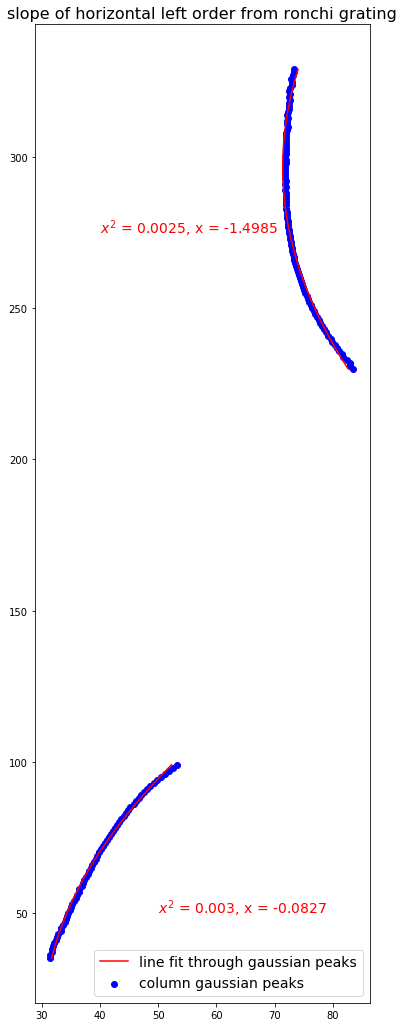

In [3178]:
#m_hdiff=str(abs(round(gausvwing2[0]-gausvwing1[0],3)))

fig,ax = plt.subplots()

fig.set_size_inches(6, 18)

ax.scatter(gverwing1, Y1, label="column gaussian peaks", color = "blue")
ax.plot(gv1(Y1),Y1,color='red',label="line fit through gaussian peaks")
ax.scatter(gverwing2, Y2, color = "blue")
ax.plot(gv2(Y2),Y2,color='red')
ax.text(50,50,'$x^2$ = ' + str(round(gausvwing1[0],4)) + ', x = ' + str(round(gausvwing1[1],4)),fontsize=14,color='red')
ax.text(40,275,'$x^2$ = ' + str(round(gausvwing2[0],4)) + ', x = ' + str(round(gausvwing2[1],4)),fontsize=14,color='red')
#ax.text(150,20,'diff between hor wings = ' + m_hdiff,fontsize=14,color='red')
ax.legend(fontsize=14)
ax.set_title("slope of horizontal left order from ronchi grating",fontsize=16) 


### Increase contrast

In [3179]:
imarray3=np.cbrt(imarray)/(np.max(imarray))

### Solver

In [3180]:
#Ah = np.array([[ -gaushwing1[0],1], [-gaushwing2[0],1] ])
#bh = np.array([gaushwing1[1],gaushwing2[1]])
#zh = np.linalg.solve(Ah,bh)
#print(zh)

#Av = np.array([[1, -gausvwing1[0]], [1,-gausvwing2[0]] ])
#bv = np.array([gausvwing1[1],gausvwing2[1]])
#zv = np.linalg.solve(Av,bv)
#print(zv)

#horsecx=zh[0]+int(sx)-bdl
#horsecy=zh[1]+int(sy)-bds

#versecx=zv[0]+int(sx)-bds
#versecy=zv[1]+int(sy)-bdl

In [3181]:
#print(horsecx)
#print(horsecy)

#print(versecx)
#print(versecy)

In [3182]:
hdr=im[0].header
#im[0].header
#hdr['ADC1']

In [3183]:
airmass = raunche_df.loc[event_timestamp]['airmass']
target_name = raunche_df.loc[event_timestamp]['target_name']

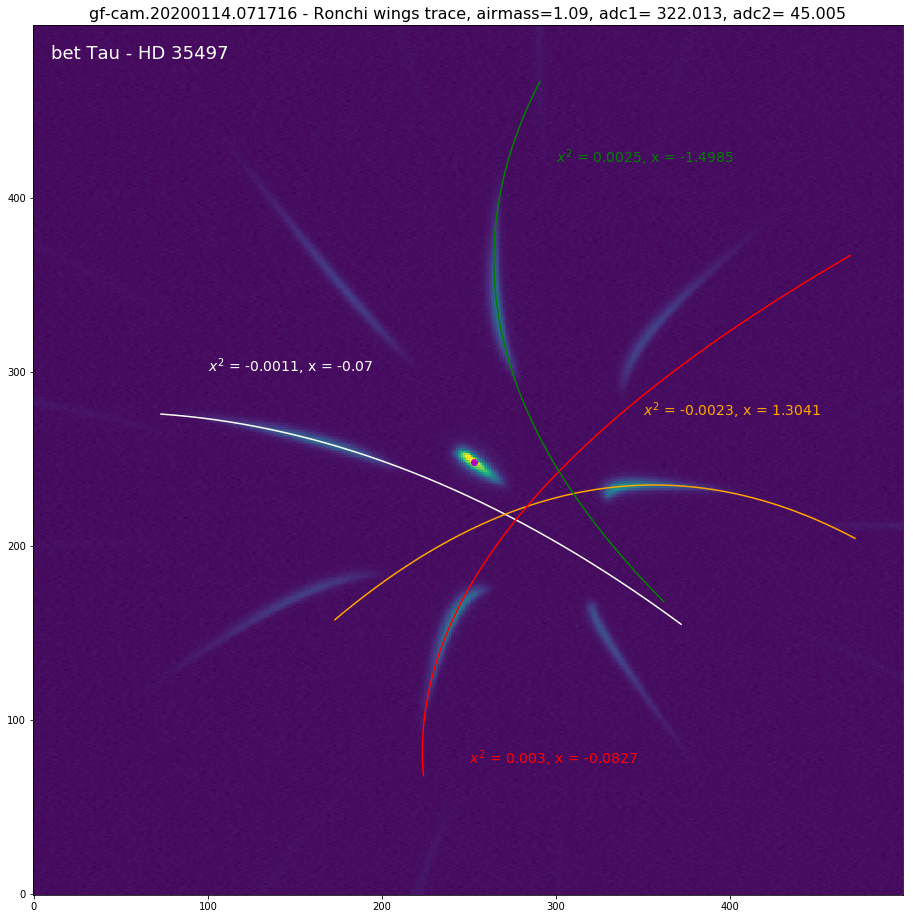

In [3184]:
ff=np.arange(0,300,1)
ff2=np.arange(100,400,1)
ff3=np.arange(0,300,1)
ff4=np.arange(100,400,1)

fig,ax = plt.subplots()

fig.set_size_inches(16, 16)
ax.imshow(imarray3,origin='lower')
#ax.imshow(imarray)

ax.plot(ff+int(sx)-bdl,gh1(ff)+int(sy)-bds,color='white')
ax.text(100,300,'$x^2$ = ' + str(round(gaushwing1[0],4)) + ', x = ' + str(round(gaushwing1[1],4)),fontsize=14,color='white')
ax.plot(ff2+int(sx)-bdl,gh2(ff2)+int(sy)-bds,color='orange')
ax.text(350,275,'$x^2$ = ' + str(round(gaushwing2[0],4)) + ', x = ' + str(round(gaushwing2[1],4)),fontsize=14,color='orange')
ax.plot(gv1(ff3)+int(sx)-bds,ff3+int(sy)-bdl,color='red')
ax.text(250,75,'$x^2$ = ' + str(round(gausvwing1[0],4)) + ', x = ' + str(round(gausvwing1[1],4)),fontsize=14,color='red')
ax.plot(gv2(ff4)+int(sx)-bds,ff4+int(sy)-bdl,color='green')
ax.text(300,420,'$x^2$ = ' + str(round(gausvwing2[0],4)) + ', x = ' + str(round(gausvwing2[1],4)),fontsize=14,color='green')
ax.set_title(filename + " - Ronchi wings trace, airmass=" + airmass + ", adc1= " 
             + hdr['ADC1'] + ", adc2= " + hdr['ADC2'] ,fontsize=16)
ax.plot(sx,sy,'mo')
ax.text(10,480,target_name,fontsize=18,color='white')

#if 0 < horsecx < 500 and 0 < horsecy < 500:
#    ax.plot(horsecx,horsecy,'cD')
#if 0 < versecx < 500 and 0 < versecx < 500:
#    ax.plot(versecx,versecy,'kD')


fig.savefig(filename + 'ronchi-wing-trace.png')

In [3185]:
last_processed = datetime.datetime.now()


fields=[event_timestamp,round(sx,2),round(sy,2),round(gaushwing1[0],4),round(gaushwing1[1],4),
        round(gaushwing2[0],4),round(gaushwing2[1],4),
        round(gausvwing1[0],4),round(gausvwing1[1],4),
        round(gausvwing2[0],4),round(gausvwing2[1],4),
        #round(horsecx,2),round(horsecy,2),round(versecx,2),round(versecy,2),
        hdr['ADC1'],hdr['ADC2'],airmass,target_name,last_processed]
with open(r'raunche_single.csv', 'a',newline='\n') as f:
    writer = csv.writer(f)
    writer.writerow(fields)

### dump out the input parameters to another csv file

In [3186]:
raunche_df=raunche_df.drop(columns='timestamp')
raunche_df.to_csv('raunche_inputs.csv')